# Project: Twitter Sentiment Analysis

## Few Methods Tried For Sentitment Analysis
### 1. Naive Bayes
#### Pros
- simple to train
- fast
- model size is small
- can work on sparse data

#### Cons
- features are independant
- word level probability distribution
- does not work well on twitter data

### 2. Doc2Vec + Multiclass Classification
#### Pros
- easy to train
- Doc2Vec model can be trained fast
- no need to train Doc2Vec model with every new data
- training classification model is fast
- method is split into 2 separate tasks and can be improved imdependantly
- Huge amount of data not required

#### Cons
- need to train Doc2Vec if domain changes or lots of new vocabulary is changed
- does not take dependencies into account
- a single work cannot change the vector document vector so much
- not best suited for Sentiment Analysis on short texts
- classification model not too complex hence cannot figure out dependencies

### 3. Language Models (Specefically ULMFiT) - Final Implemtation
#### Pros
- State of the Art Language  Model with Transfer Learning
- Can use pre-trained LM and Fine-Tune to the domain data
- Need only to Train Last few layers per domain
- Classiffiers can be bolted on the model 
- needs very few samples to achieve accuracy comparable to other SoTA models

#### Cons
- slow to train
- slow to predict single input
- fine tuning is required of last few layers for the said task
- lots of hyper-tuning options to try to get SoTA results



In [ ]:
from fastai import *
from fastai.text import *
from fastai.core import *
from fastai.vision import *
import re

In [ ]:
# downloading data
# download model data from http://localhost:8888/?token=2fa1129210e128154cbaa61adc7d06d7d36257d9f74ac075
!wget https://s3.amazonaws.com/vikrantinterviewdata/model_data.zip

In [ ]:
# point path to the folder of the extracted data
path = Path(".")

In [3]:
# Loading training csv into pandas dataframe

train_csv = path/'train.csv'
train_pd = pd.read_csv(train_csv)
train_pd.head()

,content,sentiment
0,RT @evixy_: @havocharb 🙄 ALL RIGHT SHERLOCK. E...,negative
1,@Honeybeemtb @80sbuttplug @CNN @zbyronwolf So ...,neutral
2,#Beer. #Grub. #StadiumSeating. Best place in ...,neutral
3,I want thissssssssss 😍😍😍😍😍 u have a perfect pl...,positive
4,youtu.be/D2IHY4eRdAs IF YOU DRINK DIET SODA OR...,neutral


In [4]:
# Loading evaluation csv into pandas dataframe

eval_csv = path/'evaluate.csv'
eval_pd = pd.read_csv(eval_csv)
eval_pd.head()

,content,sentiment
0,@joselynalghul I mean you GOTTA go to Grand Ce...,positive
1,** HAPPY COOKING **#MAINCUISINE #COOKING #RECI...,neutral
2,RT @RiverRatBrewery: Today is the day! It's Su...,neutral
3,I ate chili cheese fries at 1AM and watched 13...,neutral
4,The Most Popular Super Bowl Recipes in Every S...,neutral


In [ ]:
# regex patterns to remove usernames, links and email addresses from tweets
# leaving hastags intact might help in sentiment analysis

username_pat = re.compile("(?<=^|(?<=[^a-zA-Z0-9-_\.]))((RT )?@[A-Za-z0-9-_]+):?")
url_pat = re.compile('\S+\.\S+/\S+')
email_pat = re.compile('\S+@\S+\.\S+')
space_pat = re.compile('[ ]+')

In [ ]:
# label normalizer
# positive -> 1, negative -> -1, neutral -> 0
def normalize_sentiment(txt):
    if txt == "positive":
        return 1
    elif txt == "neutral":
        return 0
    elif txt == "negative":
        return -1
    return -5
  
# tweet normalizer
def normalize(txt):
    txt = re.sub(username_pat, '', txt)
    txt = re.sub(email_pat, '', txt)
    txt = re.sub(url_pat, '', txt)
    txt = re.sub(space_pat, ' ', txt)
    return txt.strip()

In [ ]:
# apply normalization on each column using different normalization functions

train_pd.content = train_pd.content.apply(normalize)
train_pd.sentiment = train_pd.sentiment.apply(normalize_sentiment)

In [ ]:
# apply normalization on each column using different normalization functions

eval_pd.content = eval_pd.content.apply(normalize)
eval_pd.sentiment = eval_pd.sentiment.apply(normalize_sentiment)

In [ ]:
# suffling data and splitting data in training/validation parts
np.random.seed(42)
rnd_idx = np.random.permutation(len(train_pd))
idx_70 = round(len(rnd_idx)*(70/100))

trn_idx = rnd_idx[:idx_70]
val_idx = rnd_idx[idx_70:]

In [ ]:
trn_texts = train_pd.loc[trn_idx, 'content'].values
trn_labels = train_pd.loc[trn_idx, 'sentiment'].values
val_texts = train_pd.loc[val_idx, 'content'].values
val_labels = train_pd.loc[val_idx, 'sentiment'].values

In [ ]:
# creating new dataframes for training, validation and testing(evaluation) data
col_names = ['labels','text']
df_trn = pd.DataFrame({'text':trn_texts, 'labels':trn_labels}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':val_labels}, columns=col_names)
df_test = pd.DataFrame({'text':eval_pd.content.values, 'labels':eval_pd.sentiment.values}, columns=col_names)

In [19]:
# training data is not very skew which is good for generalization
df_trn.labels.value_counts()

 0    49787
 1    35717
-1    26496
Name: labels, dtype: int64

In [20]:
# validation data is not very skew which is good for generalization

df_val.labels.value_counts()

 0    21213
 1    15283
-1    11504
Name: labels, dtype: int64

In [144]:
df_test.labels.value_counts()

 0    55766
 1    10477
-1     3351
Name: labels, dtype: int64

In [ ]:
# create fast.ai data bunch using training, validation and testing data frames
data_lm = TextLMDataBunch.from_df('.', train_df=df_trn, valid_df=df_val, test_df=df_test)

In [ ]:
data_lm.save('tmp_lm')

In [ ]:
# create leaner object using pretrained LM from wikipedia
learner = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)

In [ ]:
# function to find the best learning rate to fine tune the model futher
learner.lr_find()

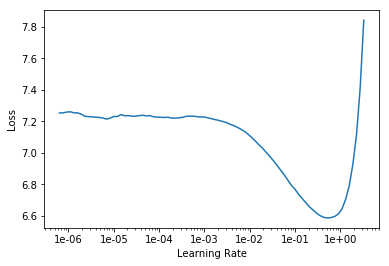

In [149]:
learner.recorder.plot()

In [150]:
# training the model but only the last layer for classification and keep rest of the pretrained parameters frozen
# this will produce a very generic and lightly fine tuned LM whcih can understand our vocabulary
learner.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.386415,4.094690,0.303533,04:09


In [30]:
# now to tune the parameters of the entire model with twitter data to make it more fine tuned to our task and dataset
learner.unfreeze()
learner.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.921386,3.789510,0.346393,04:48


In [242]:
# check how the language model is looking
learner.predict("#bad #shame", n_words=10)

'#bad #shame # apple - educational cookbook # Delicious #'

In [ ]:
# saving the encode model only for later use
learner.save_encoder("fine_enc")

In [ ]:
# Classifier data bunch with batching
# create fast.ai classification data bunch using training, validation and testing data frames
data_clas = TextClasDataBunch.from_df('./', train_df=df_trn, valid_df=df_val, test_df=df_test, vocab=data_lm.train_ds.vocab, bs=32)

In [ ]:
data_clas.save("tmp_cl")

In [ ]:
# create classifier from our fine tuned Language Model
classifier = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
classifier.load_encoder('fine_enc')

In [160]:
# find the best learning rate 
classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


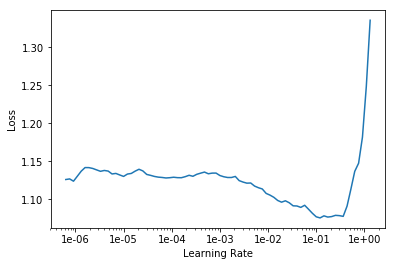

In [161]:
classifier.recorder.plot()

In [162]:
# Fine tune the last layer of LM for classification task on out data and with our labels
# keep rest of the model Frozen
classifier.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.879365,0.807349,0.640750,02:44


In [163]:
# to improve accuracy we can unfreeze just the last 2 layers to be trained and keep res of the model frozen
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(5e-3/2., 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.585506,0.451180,0.829813,03:01


In [206]:
# now we cn unfreeze the entire model and train
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(1e-3/100, 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.413215,0.320368,0.891958,05:43


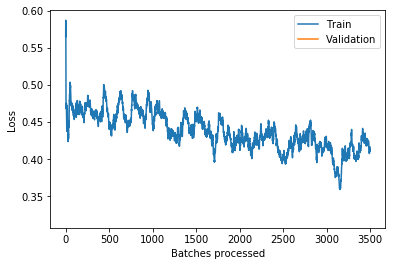

In [208]:
classifier.recorder.plot_losses()

In [ ]:
learner.save("lm.bin")
classifier.save("cl.bin")

In [ ]:
preds, y, losses = classifier.get_preds(with_loss=True)

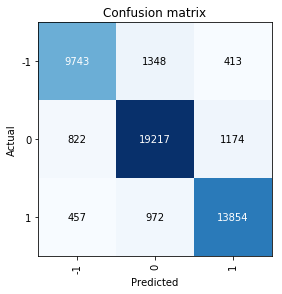

In [237]:
# validation set confusion matrix
val_interp = classifier.interpret()
val_interp.plot_confusion_matrix()

In [ ]:
train_interp = classifier.interpret(DatasetType.Train)

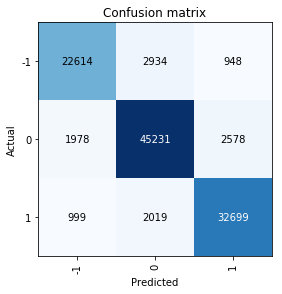

In [245]:
train_interp.plot_confusion_matrix()

In [ ]:
test_interp = classifier.interpret(DatasetType.Test)

In [ ]:

test_interp.test_interp.plot_confusion_matrix()

## Conclusion
- Comparing the model performance using accuracy metric it looks like its performaing very well with very hundreds of training samples instead of millions of samples required to train DNN models for the task. Language Models like ULMFiT allows a flexible tranfer learning mechanish as a cost of higher computation at runtime since language model needs to run to proces sentenc vector representation of the input text.
- Although accuracy metrics is not the best but we can be confident that the model is performaing good since its only getting confuesd a lot by positive and neutral tweets which is understandable since its hard for model to get sarcasm, analogy and context of the twitter post just from this data and training procedure.
- Even though the model accuracy is 90% we can still improve the model by few iteration of fine tuning until the train loss is higher than validation loss which gives indication that overfitting is not happening. But also hyper-parameter tuning is also required to get few more points in the perfermance.
- To make this model production ready we need to first figure out if its getting used realtime as the query comes or near realtime where batching can happen. The model performances increases a lot for inference when its done in batches since matrix multiplication is more effective and can be distributed. Also GPU is the intended device for training ang inference for production. Inference latency is poor for single query  predictions even on GPU. We can add multiprocessing but python is not bes suited for it.
- this notebook needs to converted to python script which should be easy but methods needs to be added for training or loading already trained models.
- the model might be exportable to common format like onnx so it can be served using a hig perfermance model server.

# NOTE
At the end due to some issue in fastai library i was not able to produce the confusion matrix for the evaluation data using batch processing. I was able to produce the correct predictions using single query loop but forgot to save it and it takes hours to generate again without batching.


